# Creating synthetic data defined from Gaussian distribution

### Things to look into : 
1. Implementing Laplace Method
2. Model uncertainties in BNN and BSSNN (run through predictions multiple times)
3. Attempting different values of \rho for BSSNN and looking at performance / KL divergence evolution

In [1]:
# PyTorch Imports
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Normal

# Basic Python Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Module Imports
from Modules.BayesLinear import BayesLinear, BLSS
from Modules.Loss import BKLLoss

import random
from sklearn.preprocessing import StandardScaler

random.seed(10)

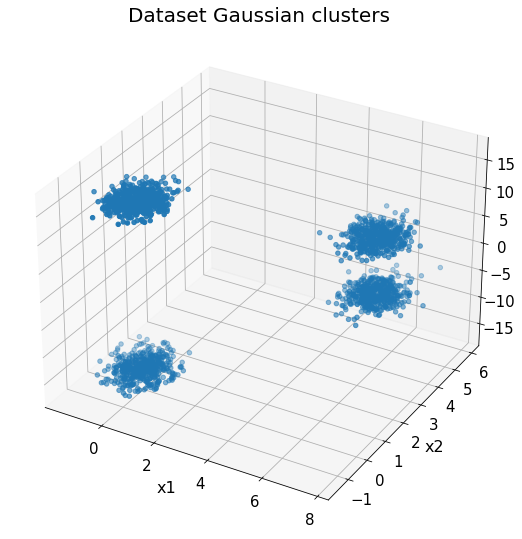

In [2]:
#center_locations = [[8, 8], [8, 4], [2, 8], [2, 4]]
center_locations = [[0, 0], [4, 6]]
X, y_true = make_blobs(n_samples=2000, centers=center_locations,
                       cluster_std=0.50, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

# Plot the data with K Means Labels
kmeans = KMeans(2, random_state=0)
labels = kmeans.fit(X).predict(X)

# Create gaussian distributed labels
mu = [-5, 5, -15, 15]
sigma = [0.5, 0.5, 0.5, 0.5]

labels = labels.astype(float)
labels0 = np.where(labels==0)[0]
labels1 = np.where(labels==1)[0]

assert len(labels0) == len(labels1), 'Error : Clusters do not have the same number of samples'
n = len(labels0)

size1 = labels0[0:int(n/2)]
size2 = labels0[int(n/2):n]
size3 = labels1[0:int(n/2)]
size4 = labels1[int(n/2):n]

s1 = np.random.normal(loc=mu[0], scale=sigma[0], size=len(size1))
s2 = np.random.normal(mu[1], sigma[1], len(size2))
s3 = np.random.normal(mu[2], sigma[2], len(size3))
s4 = np.random.normal(mu[3], sigma[3], len(size4))

#replace categorical labels with distribution
labels[size1] = s1
labels[size2] = s2
labels[size3] = s3
labels[size4] = s4

# plot 3D scatter data.
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14,7))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(X[:, 0], X[:, 1], labels)
plt.grid()
plt.title('Dataset Gaussian clusters', fontsize=20)
plt.xlabel('x1', fontsize=16)
plt.ylabel('x2', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.zaxis.set_tick_params(labelsize=15)
plt.show()

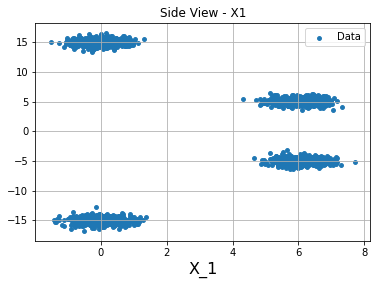

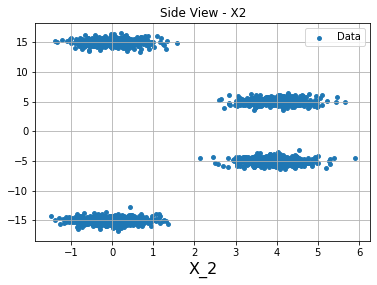

In [3]:
plt.figure()
plt.scatter(X[:, 0], labels, s=15, label='Data')
plt.title('Side View - X1')
plt.xlabel('X_1', fontsize=16)
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(X[:, 1], labels, s=15, label='Data')
plt.title('Side View - X2')
plt.xlabel('X_2', fontsize=16)
plt.grid()
plt.legend()
plt.show()

In [4]:
xx = X.copy()
x = torch.from_numpy(xx)
y = torch.from_numpy(labels)

x = x.float()
y = y.float()

## Feed-Forward Neural Network
Skal FFNN kun have en feature i output (middelværdi), eller skal vi også bestemmelse normalfordeling for data usikkerheder med denne model, for at sammenligne med BNN (ergo have 2 output features)?

In [130]:
class DenseLinear(Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(DenseLinear, self).__init__()
        self.hidden1 = nn.Linear(in_features=n_feature, out_features=n_hidden, bias=True)
        self.hidden2 = nn.Linear(in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = nn.Linear(in_features=n_hidden, out_features=n_output, bias=True)
        
    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.predict(x)

        return x
    
FFNN = DenseLinear(n_feature=2, n_hidden=100, n_output=1)
print(FFNN)

DenseLinear(
  (hidden1): Linear(in_features=2, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
)


### Training

In [131]:
n_epochs = 1000 # or whatever
batch_size = 64 # or whatever

FFNN = FFNN.float()
mse_loss = nn.MSELoss()

optimizer = optim.Adam(FFNN.parameters(),  lr=0.001)

for epoch in range(n_epochs):

    # Randomly permute indexes
    permutation = torch.randperm(x.size()[0])

    # Run batch
    for i in range(0, x.size()[0], batch_size):
        optimizer.zero_grad()
        
        indices = permutation[i:i+batch_size]
        
        batch_x, batch_y = x[indices], y[indices]
        
        prediction = FFNN(batch_x)
        
        loss = mse_loss(prediction.squeeze(), batch_y.float())

        loss.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        print('Epoch', epoch, '    Loss', loss.item())

Epoch 0     Loss 100.48267364501953
Epoch 100     Loss 107.69600677490234
Epoch 200     Loss 105.4915771484375
Epoch 300     Loss 120.55328369140625
Epoch 400     Loss 100.25777435302734
Epoch 500     Loss 144.53321838378906
Epoch 600     Loss 132.95767211914062
Epoch 700     Loss 181.26025390625
Epoch 800     Loss 98.96441650390625
Epoch 900     Loss 133.17242431640625


### Predictions

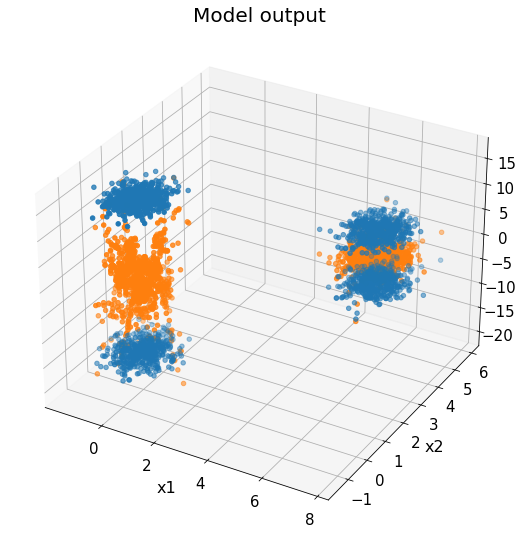

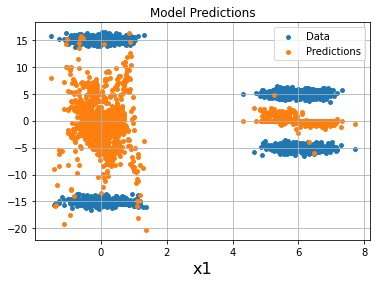

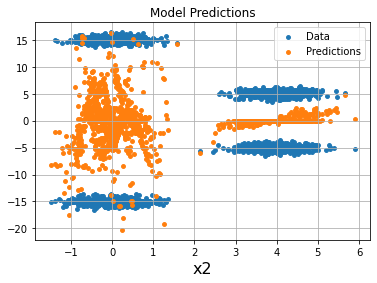

In [147]:
prediction = FFNN(x.float()).detach().numpy()

fig = plt.figure(figsize=(14,7))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(X[:, 0], X[:, 1], labels, label='Data')
ax.scatter(X[:, 0], X[:, 1], prediction, label='Predictions')
plt.grid()
plt.title('Model output', fontsize=20)
plt.xlabel('x1', fontsize=16)
plt.ylabel('x2', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.zaxis.set_tick_params(labelsize=15)
plt.show()


plt.figure()
plt.scatter(X[:, 0], y, s=15, label='Data')
plt.scatter(X[:, 0], prediction, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x1', fontsize=16)
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(X[:, 1], y, s=15, label='Data')
plt.scatter(X[:, 1], prediction, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x2', fontsize=16)
plt.grid()
plt.legend()
plt.show()

## Bayes Linear Neural Network

In [138]:
class BayesLinearNN(Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(BayesLinearNN, self).__init__()
        self.hidden1 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_feature, out_features=n_hidden, bias=True)   # hidden layer
        self.hidden2 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_output, bias=True)   # output layer
        
    def forward(self, x):
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden2(x))
        x = self.predict(x)
        
        #mu, log_std = x.chunk(2, dim=1)
        
        #dist = Normal(mu, torch.exp(log_std))

        return x
    
BNN = BayesLinearNN(n_feature=2, n_hidden=100, n_output=1)
print(BNN)

BayesLinearNN(
  (hidden1): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=100, bias=True)
  (hidden2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=100, bias=True)
  (predict): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1, bias=True)
)


### Training

In [142]:
n_epochs = 5000 # or whatever
batch_size = 64 # or whatever

BNN = BNN.float()

kl_loss = BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(BNN.parameters(),  lr=0.001)
mse_loss = nn.MSELoss()

for epoch in range(n_epochs):

    # Randomly permute indexes
    permutation = torch.randperm(x.size()[0])

    # Run batch
    for i in range(0, x.size()[0], batch_size):
        optimizer.zero_grad()
        
        indices = permutation[i:i+batch_size]
        
        batch_x, batch_y = x[indices], y[indices]
        
        #distribution = BNN(batch_x)
        prediction = BNN(batch_x)
        
        kl = kl_loss(BNN)
        
        #loss = -distribution.log_prob(batch_y.float()).sum(1).mean() + kl_weight*kl
        loss = mse_loss(prediction.squeeze(), batch_y.float()) + kl_weight*kl
        
        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        print('Epoch', epoch, '    Loss', loss.item())

Epoch 0     Loss 117.62986755371094
Epoch 500     Loss 149.76031494140625
Epoch 1000     Loss 133.97073364257812
Epoch 1500     Loss 87.60566711425781
Epoch 2000     Loss 119.14530944824219
Epoch 2500     Loss 80.31861114501953
Epoch 3000     Loss 104.24430084228516
Epoch 3500     Loss 60.93342590332031
Epoch 4000     Loss 139.00050354003906
Epoch 4500     Loss 59.57012939453125


### Predictions

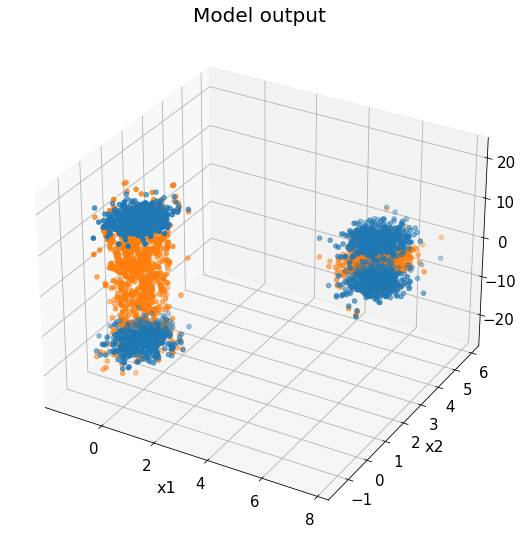

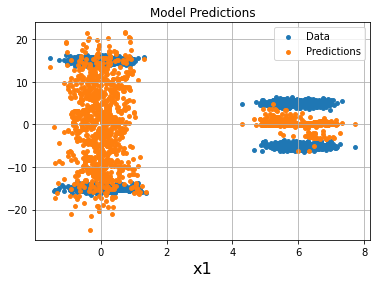

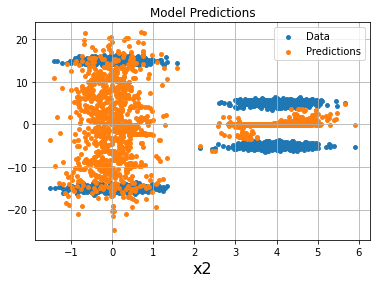

In [144]:
prediction = BNN(x.float()).detach().numpy()

fig = plt.figure(figsize=(14,7))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(X[:, 0], X[:, 1], labels, label='Data')
ax.scatter(X[:, 0], X[:, 1], prediction, label='Predictions')
plt.grid()
plt.title('Model output', fontsize=20)
plt.xlabel('x1', fontsize=16)
plt.ylabel('x2', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.zaxis.set_tick_params(labelsize=15)
plt.show()

plt.figure()
plt.scatter(X[:, 0], y, s=15, label='Data')
plt.scatter(X[:, 0], prediction, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x1', fontsize=16)
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(X[:, 1], y, s=15, label='Data')
plt.scatter(X[:, 1], prediction, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x2', fontsize=16)
plt.grid()
plt.legend()
plt.show()

## Spectral Smoothing
Only done for gradient computations during training.
We must reparametrise the inputs to the Gaussian distributions (\mu and \sigma) by applying an opertator from the OU semigroup. This created a correlated variable. 

In [10]:
class BayesLinearSpectralSmoothing(Module):
    def __init__(self, rho, n_feature, n_hidden, n_output):
        super(BayesLinearSpectralSmoothing, self).__init__()
        self.hidden1 = BLSS(rho=rho, prior_mu=0, prior_sigma=0.1, in_features=n_feature, out_features=n_hidden, bias=True)   # hidden layer
        self.hidden2 = BLSS(rho=rho, prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = BLSS(rho=rho, prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_output, bias=True)   # output layer
        
    def forward(self, x):
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden2(x))
        x = self.predict(x)

        return x
    
BSSNN = BayesLinearSpectralSmoothing(rho=0.6, n_feature=2, n_hidden=100, n_output=1)
print(BSSNN)

BayesLinearSpectralSmoothing(
  (hidden1): BLSS(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=100, bias=True)
  (hidden2): BLSS(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=100, bias=True)
  (predict): BLSS(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1, bias=True)
)


In [11]:
n_epochs = 5000 # or whatever
batch_size = 64 # or whatever

BSSNN = BSSNN.float()

kl_loss = BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(BSSNN.parameters(),  lr=0.001)
mse_loss = nn.MSELoss()

for epoch in range(n_epochs):

    # Randomly permute indexes
    permutation = torch.randperm(x.size()[0])

    # Run batch
    for i in range(0, x.size()[0], batch_size):
        optimizer.zero_grad()
        
        indices = permutation[i:i+batch_size]
        
        batch_x, batch_y = x[indices], y[indices]
        
        #distribution = BNN(batch_x)
        prediction = BSSNN(batch_x)
        
        kl = kl_loss(BSSNN)
        
        #loss = -distribution.log_prob(batch_y.float()).sum(1).mean() + kl_weight*kl
        loss = mse_loss(prediction.squeeze(), batch_y.float()) + kl_weight*kl
        
        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        print('Epoch', epoch, '    Loss', loss.item())

Epoch 0     Loss 102.62479400634766
Epoch 500     Loss 121.65489196777344
Epoch 1000     Loss 98.75117492675781
Epoch 1500     Loss 68.8784408569336
Epoch 2000     Loss 113.36534118652344
Epoch 2500     Loss 67.0341567993164
Epoch 3000     Loss 109.03099060058594
Epoch 3500     Loss 111.36153411865234
Epoch 4000     Loss 59.84428405761719
Epoch 4500     Loss 116.97075653076172


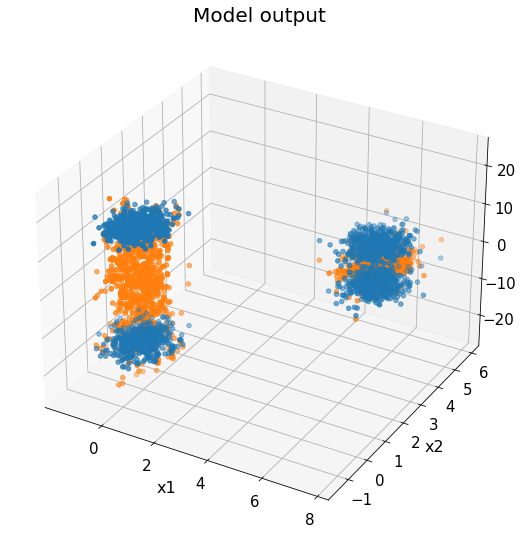

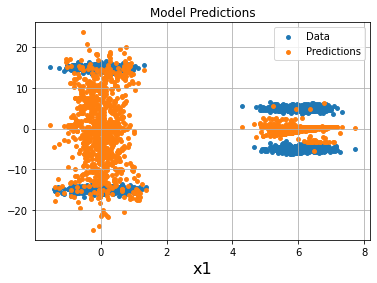

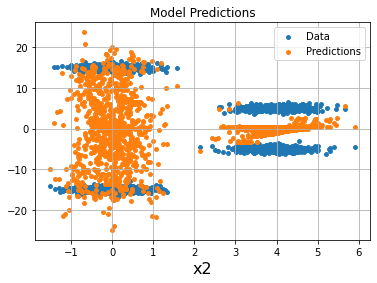

In [13]:
prediction = BSSNN(x.float()).detach().numpy()

fig = plt.figure(figsize=(14,7))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(X[:, 0], X[:, 1], labels, label='Data')
ax.scatter(X[:, 0], X[:, 1], prediction, label='Predictions')
plt.grid()
plt.title('Model output', fontsize=20)
plt.xlabel('x1', fontsize=16)
plt.ylabel('x2', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.zaxis.set_tick_params(labelsize=15)
plt.show()

plt.figure()
plt.scatter(X[:, 0], y, s=15, label='Data')
plt.scatter(X[:, 0], prediction, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x1', fontsize=16)
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(X[:, 1], y, s=15, label='Data')
plt.scatter(X[:, 1], prediction, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x2', fontsize=16)
plt.grid()
plt.legend()
plt.show()

## Laplace Transform